In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from fastnc import fastnc, bispectrum

# Bispectrum

## Instantiate the class:

In [2]:
# Instantiate with config:
config = {'Lmax':30}
bs = bispectrum.BispectrumHalofit(config)

# Instantiate with kwargs:
# bs = bispectrum.BispectrumHalofit(Lmax=20)

## Set cosmology:

In [3]:
# This is needed to perform line-of-sight integration over matter bispectrum
# Especially for bispectrum class based on Halofit, we need to supply wCDM model to explicitly set w EoS parameter
# and amplitude of LSS, sigma8, and spectral index, n, need to be includes in the meta data of cosmo instance
# Here we take predefined wCDM model, where w=-1.0, and other cosmological parameter are set to be LCDM values from Planck2018
cosmo = bispectrum.wPlanck18
# Set
bs.set_cosmology(cosmo)

## Set source redshift bin distribution:

In [5]:
# The first argument is the list of redshift bins and 
# the second argument is the list of distribution on the bins.
# The distribution do **not** have to be normalized by user, and
# the code will normalize it internally.

# If the distribution is a delta function, 
# you can set a scalar value for the sample.

# Here is an example:
# The first sample: Gaussian centering at z=1.0
zs_1 = np.arange(0.5, 1.5)
pzs_1= np.exp(-(zs_1-1.0)**2.0/0.1**2/2.0)
# The second sample: delta function at z=2.0
zs_2 = 2.0
pzs_2 = 1.0

# Set the distributions
# The code will name the samples as '0', '1', ... automatically
bs.set_source_distribution([zs_1, zs_2], [pzs_1, pzs_2])

# You can use your own name for the samples
# name_1 = 'sample_1'
# name_2 = 'sample_2'
# bs.set_source_distribution([zs_1, zs_2], [pzs_1, pzs_2], [name_1, name_2])

# After setting the distribution, you need to run computation
bs.compute_kernel()

## Set linear power spectrum:

In [6]:
# The shape of matter power spectrum is independent of redshift
# and the amplitude is normalized to z=0, so that it gives input sigma8
k, pklin = np.loadtxt('pklin_P18.dat', unpack=True)
bs.set_pklin(k, pklin)
# linear growth rate is also needed for the computation
z, lgr = np.loadtxt('lgr_P18.dat', unpack=True)
bs.set_lgr(z, lgr)

## Set support range of scale/triangle (optional):

In [7]:
# Set support range of scale:
# This is typically **not** needed because the class already 
# has its own support range by default by developper.
# bs.set_ell1mu_range(ell1min, ell2max, epmu)

## Set window function on bispectrum (optional):

In [8]:
# Set window function multiplied on bispectrum:
# For example, pixel window function for pixelized survey data
# window = lambda ell1, ell2, ell3: np.exp(-(ell1**2+ell2**2+ell3**2)/10**3)
# bs.set_window_function(window)

## Ininialize interpolation of bispectrum:

In [9]:
# This will prepare the interpolation for all the sample combinations
# bs.interpolate()

# If you want to interpolate only specific sample combinations,
# you can tell with scombs keyword, stands for sample combinations.
# This is a list of tuples, each of which is the sample combination.

# For example, if you are interested only in auto bispectrum,
scombs = [('0','0','0'), ('1','1','1')]
%time bs.interpolate(scombs=scombs)

CPU times: user 7.71 s, sys: 1.17 s, total: 8.87 s
Wall time: 9.26 s


## Getting bispectrum

CPU times: user 34.3 ms, sys: 34.3 ms, total: 68.6 ms
Wall time: 72.3 ms
CPU times: user 16.5 ms, sys: 1.87 ms, total: 18.4 ms
Wall time: 18.4 ms


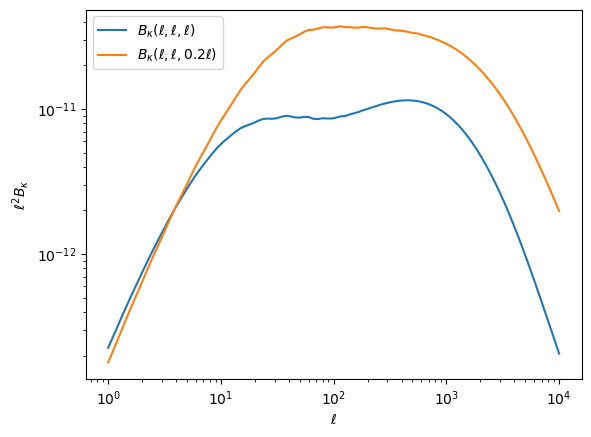

In [10]:
# Get bispectrum
ell = np.logspace(0, 4, 100)

# Example, get kappa bispectrum as a function of scale ell for equilateral triangle
%time b_kappa_equi = bs.kappa_bispectrum(ell, ell, ell, scomb=('0','0','0'))
# Example, get kappa bispectrum as a function of scale ell for isoceles triangle
%time b_kappa_isoc = bs.kappa_bispectrum(ell, ell, ell*0.2, scomb=('0','0','0'))


plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2 B_\kappa$')
plt.loglog(ell, ell**2*b_kappa_equi, label=r'$B_\kappa(\ell, \ell, \ell)$')
plt.loglog(ell, ell**2*b_kappa_isoc, label=r'$B_\kappa(\ell, \ell, 0.2\ell)$')
plt.legend()
plt.show()

## Initialize multipole:

In [11]:
# This will prepare the interpolation for all the sample combinations
%time bs.decompose(scombs=scombs)

CPU times: user 1.93 s, sys: 337 ms, total: 2.27 s
Wall time: 1.05 s


0

# Natural component

## Instantiate the class

In [12]:
# side length bin
t1_arcmin = np.logspace(0, 2, 20+1)[:-1]
t1_radian = np.deg2rad(t1_arcmin/60.0)
dlnt = np.log(t1_radian[1]/t1_radian[0])
# Opening angle bin
phi = np.linspace(0, 2*np.pi, 40)

# Instantiate with config:
# Note: This will take a long time for the first time to prepare mode-coupling function in cache.
config = {'Lmax':20, 'Mmax':40, 't1':t1_radian, 'phi':phi, 'dlnt':dlnt}
fnc = fastnc.FastNaturalComponents(config)

# Instantiate with kwargs:
# fnc = fastnc.FastNaturalComponents(Lmax=20, Mmax=40, t1=t1_radian, phi=phi, dlnt=dlnt)

Loading cache from cache at /Users/sugiyamasunao/.fastnc/coupling-1.npz
(L,M) = (20, 40)/861

## Set bispectrum:

In [13]:
fnc.set_bispectrum(bs)

Tuning FFT bins...


## Compute natural components:

In [14]:
# This module does not hold the results for all the sample combinations on memory because this can be huge.
# Instead you need to specify the sample combination you want to compute.
# If you want to get natural components for many sample combinations, 
# you can call this function many times over different sample combinations.
args = dict(scomb = ('0','0','0'))
%time fnc.compute(**args)

CPU times: user 631 ms, sys: 145 ms, total: 776 ms
Wall time: 788 ms


## Getting the predicted natural component and its multipoles

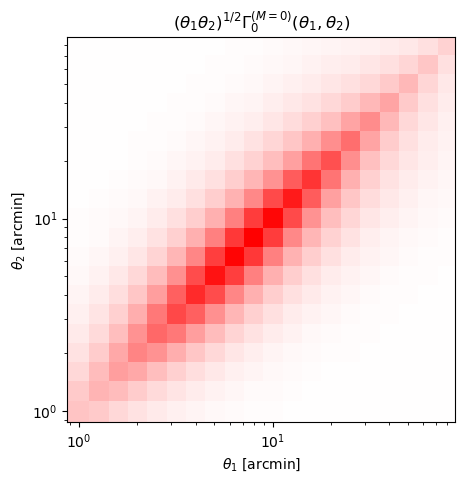

In [16]:
# Access to the natural-component multipoles:
t1, t2, M = fnc.get_bins(bin_type='multipole', t1_unit='arcmin', mesh=False)
Mmax = fnc.config_multipole['Mmax']
Gamma0M = fnc.Gamma0M

# Example: Plotting M=0th multipole of 0-th natural component
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta_1$ [arcmin]')
plt.ylabel(r'$\theta_2$ [arcmin]')
plt.title(r'$(\theta_1\theta_2)^{1/2}\Gamma_0^{(M=0)}(\theta_1, \theta_2)$')
z = Gamma0M[:, :, Mmax]*np.sqrt(t1[:,None]*t2[None,:])
vmax = np.max(np.abs(z))
plt.pcolormesh(t1, t2, z, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.show()

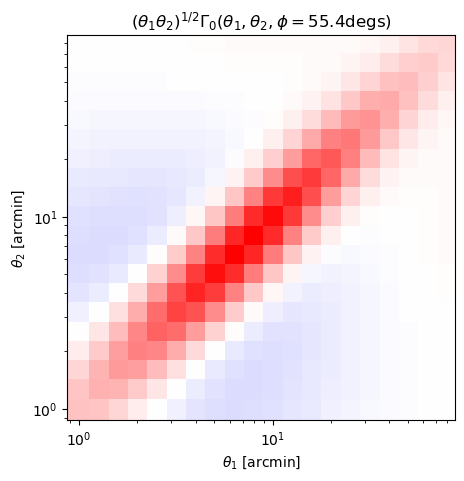

In [22]:
# Access to the natural component:
t1, t2, phi = fnc.get_bins(bin_type='SAS', t1_unit='arcmin', mesh=False)
Gamma0 = fnc.Gamma0

# Example: Plotting of 0-th natural component for phi=pi/3
idx = np.argmin(np.abs(phi - np.pi/3))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta_1$ [arcmin]')
plt.ylabel(r'$\theta_2$ [arcmin]')
plt.title(r'$(\theta_1\theta_2)^{{1/2}}\Gamma_0(\theta_1, \theta_2, \phi={:.1f}{{\rm degs}})$'.format(phi[idx]/np.pi*180.0))
z = Gamma0[:, :, idx].real*np.sqrt(t1[:,None]*t2[None,:])
vmax = np.max(np.abs(z))
plt.pcolormesh(t1, t2, z, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.show()